In [18]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from skimage.feature import hog  
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [19]:
import os
print(os.listdir('/kaggle/input/new-dataset-fai/Dataset_FAI'))

['Circle', 'Triangles', 'Squares']


In [20]:
def load_images_from_folder(base_folder, image_size=(224, 224)):
    features = []
    y_shape = []
    y_quality = []
    
    shape_to_label = {'Squares': 0, 'Circle': 1, 'Triangles': 2}
    quality_to_label = {'perfect': 0 ,'medium': 1 ,'iregullar': 2 }
    
    valid_ext = {'.png', '.jpg', '.jpeg'}
    
    for shape in ['Squares', 'Circle', 'Triangles']:
        shape_folder = os.path.join(base_folder, shape)
        
        if not os.path.exists(shape_folder):
            continue
            
        shape_label = shape_to_label[shape]
        
        for subdir, _, files in os.walk(shape_folder):
            quality_name = os.path.basename(subdir).lower()  
            
            if quality_name not in quality_to_label:
                continue
                
            quality_label = quality_to_label[quality_name]
            
            for file in files:
                _, ext = os.path.splitext(file)
                if ext.lower() in valid_ext:
                    img_path = os.path.join(subdir, file)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    
                    if img is not None:
                        img_resized = cv2.resize(img, image_size, interpolation=cv2.INTER_LANCZOS4)
                        
                        fd = hog(img_resized,
                                 orientations=9,
                                 pixels_per_cell=(16, 16),
                                 cells_per_block=(2, 2),
                                 block_norm='L1',
                                 transform_sqrt=True)
                        
                        features.append(fd)
                        y_shape.append(shape_label)
                        y_quality.append(quality_label)
    
    return np.array(features), np.array(y_shape), np.array(y_quality)

In [21]:
root_base = '/kaggle/input/new-dataset-fai/Dataset_FAI'
X_all, y_all_shape, y_all_quality = load_images_from_folder(root_base)

print(f"Loaded total images: {X_all.shape[0]}")  # Should be 1575 now

# Split code remains the same as before
X_train, X_temp, y_train_shape, y_temp_shape = train_test_split(
    X_all, y_all_shape, test_size=0.3, stratify=y_all_shape, random_state=42
)
y_train_quality, y_temp_quality = train_test_split(
    y_all_quality, test_size=0.3, stratify=y_all_shape, random_state=42
)

X_val, X_test, y_val_shape, y_test_shape = train_test_split(
    X_temp, y_temp_shape, test_size=1/3, stratify=y_temp_shape, random_state=42
)
y_val_quality, y_test_quality = train_test_split(
    y_temp_quality, test_size=1/3, stratify=y_temp_shape, random_state=42
)

print(f"Train: {X_train.shape[0]} images")
print(f"Validation: {X_val.shape[0]} images")
print(f"Test: {X_test.shape[0]} images")

Loaded total images: 1575
Train: 1102 images
Validation: 315 images
Test: 158 images


In [22]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"Loaded - Train: {X_train.shape[0]} samples ({X_train.shape[1]} HOG features each)")
print(f"Validation: {X_val.shape[0]}, Test: {X_test.shape[0]}")

Loaded - Train: 1102 samples (6084 HOG features each)
Validation: 315, Test: 158



Shape Validation Report:
               precision    recall  f1-score   support

      Square       0.80      0.87      0.83       108
      Circle       0.96      0.80      0.87       107
    Triangle       0.84      0.90      0.87       100

    accuracy                           0.86       315
   macro avg       0.86      0.86      0.86       315
weighted avg       0.86      0.86      0.86       315

Shape Test Metrics: Accuracy=0.8734, Precision=0.8799, Recall=0.8745, F1=0.8736
              precision    recall  f1-score   support

      Square       0.83      0.89      0.86        55
      Circle       0.95      0.79      0.87        53
    Triangle       0.85      0.94      0.90        50

    accuracy                           0.87       158
   macro avg       0.88      0.87      0.87       158
weighted avg       0.88      0.87      0.87       158



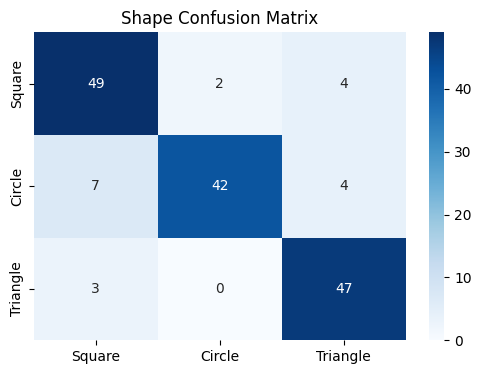


Quality Validation Report:
               precision    recall  f1-score   support

     Perfect       0.95      0.32      0.47        60
      Medium       0.63      0.57      0.60       127
   Irregular       0.52      0.73      0.61       128

    accuracy                           0.59       315
   macro avg       0.70      0.54      0.56       315
weighted avg       0.65      0.59      0.58       315

Quality Test Metrics: Accuracy=0.6139, Precision=0.6633, Recall=0.5439, F1=0.5583
              precision    recall  f1-score   support

     Perfect       0.78      0.26      0.39        27
      Medium       0.63      0.67      0.65        63
   Irregular       0.59      0.71      0.64        68

    accuracy                           0.61       158
   macro avg       0.66      0.54      0.56       158
weighted avg       0.63      0.61      0.60       158



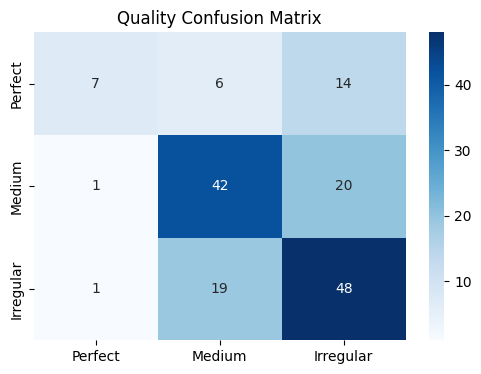

In [23]:
def train_and_evaluate_svm(X_train, y_train, X_val, y_val, X_test, y_test, class_names, target_name):
    svm = SVC(kernel='rbf', C=1.0, gamma='scale')
    svm.fit(X_train, y_train)
    
    # Validate
    y_val_pred = svm.predict(X_val)
    print(f"\n{target_name} Validation Report:\n", classification_report(y_val, y_val_pred, target_names=class_names))
    
    # Test
    y_test_pred = svm.predict(X_test)
    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred, average='macro')
    rec = recall_score(y_test, y_test_pred, average='macro')
    f1 = f1_score(y_test, y_test_pred, average='macro')
    print(f"{target_name} Test Metrics: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")
    print(classification_report(y_test, y_test_pred, target_names=class_names))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{target_name} Confusion Matrix")
    plt.show()
    
    return svm

# Class names
shape_classes = ['Square', 'Circle', 'Triangle']
quality_classes = ['Perfect', 'Medium', 'Irregular']

# Train for Shape
svm_shape = train_and_evaluate_svm(X_train, y_train_shape, X_val, y_val_shape, X_test, y_test_shape, shape_classes, "Shape")

# Train for Quality
svm_quality = train_and_evaluate_svm(X_train, y_train_quality, X_val, y_val_quality, X_test, y_test_quality, quality_classes, "Quality")

In [24]:
import cv2
from skimage.feature import hog

def predict_new_image(image_path, svm_shape, svm_quality, scaler,
                      shape_classes, quality_classes, image_size=(224, 224)):

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Could not read image:", image_path)
        return None, None

    img_resized = cv2.resize(img, image_size, interpolation=cv2.INTER_LANCZOS4)

    fd = hog(
        img_resized,
        orientations=9,
        pixels_per_cell=(16, 16),
        cells_per_block=(2, 2),
        block_norm='L1',
        transform_sqrt=True,
        visualize=False
    )

    features = scaler.transform([fd])

    shape_pred = shape_classes[svm_shape.predict(features)[0]]
    quality_pred = quality_classes[svm_quality.predict(features)[0]]

    return shape_pred, quality_pred

In [25]:
image_path = "/kaggle/input/new-dataset-fai/Dataset_FAI/Squares/Iregullar/1_15365.jpg"

shape, quality = predict_new_image(
    image_path,
    svm_shape=best_shape_model,
    svm_quality=best_quality_model,
    scaler=scaler,
    shape_classes=shape_classes,
    quality_classes=quality_classes
)

print("Predicted Shape:", shape)
print("Predicted Quality:", quality)


Predicted Shape: Square
Predicted Quality: Irregular
